ECE 5460, Au23

Solution for PyTorch Tutorial - final model only

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

norm_mean = [0.485, 0.456, 0.406]  # mean
norm_std = [0.229, 0.224, 0.225]  # std

transform_train = transforms.Compose([
    
    transforms.RandomHorizontalFlip(), 
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

batch_size = 4

ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# spliting training into train and validation
generator = torch.Generator().manual_seed(5460)
(trainset, valset) = torch.utils.data.random_split(ds, [0.8, 0.2], generator=generator)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We will use a convolutional network for classification.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # resnet design
        out = self.relu(out)
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = Block(3, 64, stride=1)
        self.layer2 = Block(64, 128, stride=2)
        self.layer3 = Block(128, 256, stride=2)
        self.layer4 = Block(256, 512, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.layer5(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = Net()

Define a loss function and optimizer

In [3]:
import torch.optim as optim

num_epochs = 50
lr = 0.001
momentum = 0.9
weight_decay = 5e-4


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) #Experiment with momentum term and other learning rates

Define training function

In [4]:
def train_step(model, inputs, labels):
  # zero the parameter gradients
  optimizer.zero_grad()

  # forward call
  outputs = model(inputs)

  # calculate loss
  loss = criterion(outputs, labels)

  # back propagation and optimization
  loss.backward()
  optimizer.step()

  return loss

Define evaluation function

Same can be used for testing

In [5]:
def val_step(model, inputs, labels):
  # get inputs and labels from given batch
  with torch.no_grad():
    outputs = model(inputs)

    # calculate the predicted class
    _, predicted = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)
    correct_pred = (predicted == labels).sum().item() # correctly classified samples of the current batch
  return correct_pred, loss

Main training and validation

In [6]:
import time
num_epochs = 50 # change this to a larger number to train the final network


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("using device: ", device)


model = model.to(device)

val_acc_log = []
val_loss_log = []

for i in range(num_epochs):
  running_loss = 0
  for j, batch in enumerate(trainloader):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # training step
    loss = train_step(model, inputs, labels)
    running_loss += loss.item()

    # print some statistics
    if (j+1) % 1000 == 0 :
      print("epoch {}, step = {}, running loss = {:.4f}".format(i, str(j+1).zfill(5), running_loss / 1000))
      running_loss = 0



  # validation at the end of each epoch
  total_correct_pred = 0
  val_loss = []
  for _, batch in enumerate(valloader):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    curr_correct_pred, curr_loss = val_step(model, inputs, labels)

    # keep track of corrected samples and loss
    total_correct_pred += curr_correct_pred
    val_loss.append(curr_loss.item())

  val_loss = torch.Tensor(val_loss).mean()
  acc = total_correct_pred / len(valset)
  print("val accuracy: {:.2f}, avg loss = {:.3f}".format(100*acc, val_loss))
  val_acc_log.append(acc * 100)
  val_loss_log.append(val_loss.item())

  # save the checkpoint
  torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'epoch_{}_val_acc_{}.pt'.format(i, 100*acc))




using device:  cuda:0
epoch 0, step = 01000, running loss = 2.0423
epoch 0, step = 02000, running loss = 1.8192
epoch 0, step = 03000, running loss = 1.7383
epoch 0, step = 04000, running loss = 1.6196
epoch 0, step = 05000, running loss = 1.5536
epoch 0, step = 06000, running loss = 1.4446
epoch 0, step = 07000, running loss = 1.4143
epoch 0, step = 08000, running loss = 1.3532
epoch 0, step = 09000, running loss = 1.3220
epoch 0, step = 10000, running loss = 1.2883
val accuracy: 55.18, avg loss = 1.242
epoch 1, step = 01000, running loss = 1.2211
epoch 1, step = 02000, running loss = 1.2139
epoch 1, step = 03000, running loss = 1.1665
epoch 1, step = 04000, running loss = 1.1507
epoch 1, step = 05000, running loss = 1.1252
epoch 1, step = 06000, running loss = 1.1162
epoch 1, step = 07000, running loss = 1.0888
epoch 1, step = 08000, running loss = 1.0730
epoch 1, step = 09000, running loss = 1.0498
epoch 1, step = 10000, running loss = 0.9914
val accuracy: 63.93, avg loss = 1.015
ep

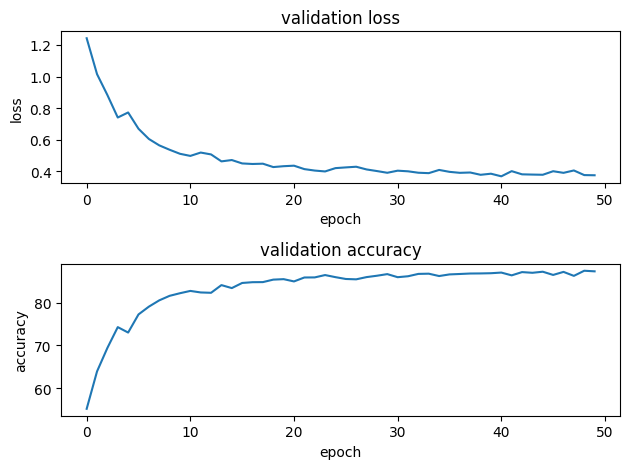

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)
ax[0].plot(val_loss_log)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('validation loss')


ax[1].plot(val_acc_log)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('validation accuracy')
plt.tight_layout()

Testing

The other things to do is to calculate the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to see the accuracy of individual classes.

In [8]:
from os import access
total_correct_pred = 0

for i, batch in enumerate(testloader):
  inputs, labels = batch
  inputs = inputs.to(device)
  labels = labels.to(device)

  curr_correct_pred, _ = val_step(model, inputs, labels)

  # adding up correctly predicted samples
  total_correct_pred += curr_correct_pred

# total accuracy
acc = total_correct_pred / len(testloader.dataset)
print("testing accuracy: {:.2f}%".format(100*acc))

testing accuracy: 86.85%


In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for batch in testloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 87 %
Accuracy of   car : 95 %
Accuracy of  bird : 78 %
Accuracy of   cat : 80 %
Accuracy of  deer : 86 %
Accuracy of   dog : 82 %
Accuracy of  frog : 88 %
Accuracy of horse : 90 %
Accuracy of  ship : 89 %
Accuracy of truck : 88 %
